In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
def read_data(file_name):
    # Read the data with its path location
    try:
        data = pd.read_csv(file_name)
        return data
    except Exception:
        sys.exit(1)

In [3]:
def trainValTestSplit(data):
    # Split the data into train, validation, test
    shuffled = data.sample(frac=1, random_state=1)
    dataSize = len(shuffled)
    train = shuffled[:int(dataSize * 0.7)]
    val = shuffled[int(dataSize * 0.7):int(dataSize * 0.8)]
    test = shuffled[int(dataSize * 0.8):]
    return train, val, test

In [4]:
def normalize(X, min, max):
    # Normalize the features
    X = (X - min) / (max - min)
    return X

In [5]:
def get_data(file_location):
    # Get X_train, X_val, X_test, y_train, y_val, y_test data
    data = read_data(file_location)

    train, val, test = trainValTestSplit(data)
    minVal = train.iloc[:, :-1].min()
    maxVal = train.iloc[:, :-1].max()

    X_train = np.array(normalize(train.iloc[:, :-1], minVal, maxVal))
    X_val = np.array(normalize(val.iloc[:, :-1], minVal, maxVal))
    X_test = np.array(normalize(test.iloc[:, :-1], minVal, maxVal))

    y_train = np.array(train.iloc[:, -1:])
    y_val = np.array(val.iloc[:, -1:])
    y_test = np.array(test.iloc[:, -1:])

    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
def getConfusionMatrix(y_true, y_pred):
    # Get the confusion matrix
    y_true = pd.Categorical(y_true.ravel())
    y_pred = pd.Categorical(y_pred.ravel())
    confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], dropna=False)
    sn.heatmap(confusion_matrix, cmap="Blues", annot=True)
    return confusion_matrix

In [7]:
def getValAccPlot(val_acc, paramaterName):
    # Get the accuracy plot for every epoch with validation set
    title = 'Validation Accuracy For Every Epoch With Different ' + paramaterName
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.plot(val_acc)

In [8]:
absolutePath = input('Enter the file location of the dataset: ')
X_train, X_val, X_test, y_train, y_val, y_test = get_data(absolutePath)

In [9]:
print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_val shape: {}".format(y_val.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (42000, 12)
X_val shape: (6000, 12)
X_test shape: (12000, 12)
y_train shape: (42000, 1)
y_val shape: (6000, 1)
y_test shape: (12000, 1)


In [10]:
def sigmoid(z):
    # Sigmoid function
    s = 1 / (1 + np.exp(-z))
    return s

In [11]:
def gaussianInitialization(dimension):
    # Initialize weights with gaussian distribution
    np.random.seed(50)
    p = np.random.normal(loc=0, scale=1, size=(dimension, 1))
    return p

In [12]:
def uniformInitialization(dimension):
    # Initialize weights with uniform distribution
    np.random.seed(50)
    p = np.random.uniform(size=(dimension, 1))
    return p

In [13]:
def zeroInitialization(dimension):
    # Initialize weights with zero
    p = np.zeros((dimension, 1))
    return p

In [14]:
def getAccuracy(y_true, y_pred):
    # Get the accuracy
    accuracyBool = (y_true.ravel() == y_pred.ravel())
    accuracy = np.count_nonzero(accuracyBool) / accuracyBool.shape[0]
    return accuracy

In [15]:
class LogisticRegression:
    def __init__(self, epochs=100, learningRate=0.001, batchSize=64, initialization='gaussian'):
        self.epochs = epochs
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.initialization = {'gaussian': lambda dimension: gaussianInitialization(dimension),
                               'uniform': lambda dimension: uniformInitialization(dimension),
                               'zero': lambda dimension: zeroInitialization(dimension)}[initialization]

    def fit(self, X_train, y_train, X_val, y_val):
        # Train the logistic function
        m = X_train.shape[0]
        # Initialize weights
        w = self.initialization(X_train.shape[1])
        b = self.initialization(1)
        # Find the iteration number according to batch size
        if m % self.batchSize == 0:
            iterationNo = m // self.batchSize
        else:
            iterationNo = m // self.batchSize + 1
        val_acc = []
        for epoch in range(self.epochs):  # for every epoch
            for batch in range(iterationNo):  # for every batch
                # Calculate batch indices
                startIdx = batch * self.batchSize
                endIdx = startIdx + self.batchSize
                # The final batch (it cannot be the same size as others)
                if batch == iterationNo - 1:
                    prob = sigmoid(np.dot(X_train[startIdx:], w) + b)
                    dw = np.dot(X_train[startIdx:].T, (prob - y_train[startIdx:]))
                    db = np.sum(prob - y_train[startIdx:])
                # All other batches
                else:
                    prob = sigmoid(np.dot(X_train[startIdx:endIdx], w) + b)
                    dw = np.dot(X_train[startIdx:endIdx].T, (prob - y_train[startIdx:endIdx]))
                    db = np.sum(prob - y_train[startIdx:endIdx])
                # Update rule
                w -= self.learningRate * dw
                b -= self.learningRate * db
            # Calculate validation accuracy for every epoch
            y_pred = self.predict(w, b, X_val, 0.5)
            val_accuracy = getAccuracy(y_pred, y_val)
            val_acc.append(val_accuracy)
            print('Epoch', epoch, 'finished. Accuracy is', val_accuracy)
        return w, b, val_acc

    def predict(self, w, b, X, threshold):
        # Predict the examples with logistic function and founded weights
        y_pred = np.zeros(X.shape[0])
        prob = sigmoid(np.dot(X, w) + b)
        for i in range(prob.shape[0]):
            if prob[i, 0] > threshold:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
        return y_pred


Start training for batch size = 42000 

Epoch 0 finished. Accuracy is 0.374
Epoch 1 finished. Accuracy is 0.626
Epoch 2 finished. Accuracy is 0.626
Epoch 3 finished. Accuracy is 0.374
Epoch 4 finished. Accuracy is 0.626
Epoch 5 finished. Accuracy is 0.6263333333333333
Epoch 6 finished. Accuracy is 0.374
Epoch 7 finished. Accuracy is 0.626
Epoch 8 finished. Accuracy is 0.6316666666666667
Epoch 9 finished. Accuracy is 0.374
Epoch 10 finished. Accuracy is 0.626
Epoch 11 finished. Accuracy is 0.6365
Epoch 12 finished. Accuracy is 0.374
Epoch 13 finished. Accuracy is 0.626
Epoch 14 finished. Accuracy is 0.6401666666666667
Epoch 15 finished. Accuracy is 0.374
Epoch 16 finished. Accuracy is 0.626
Epoch 17 finished. Accuracy is 0.6408333333333334
Epoch 18 finished. Accuracy is 0.37683333333333335
Epoch 19 finished. Accuracy is 0.626
Epoch 20 finished. Accuracy is 0.643
Epoch 21 finished. Accuracy is 0.4031666666666667
Epoch 22 finished. Accuracy is 0.626
Epoch 23 finished. Accuracy is 0.65833

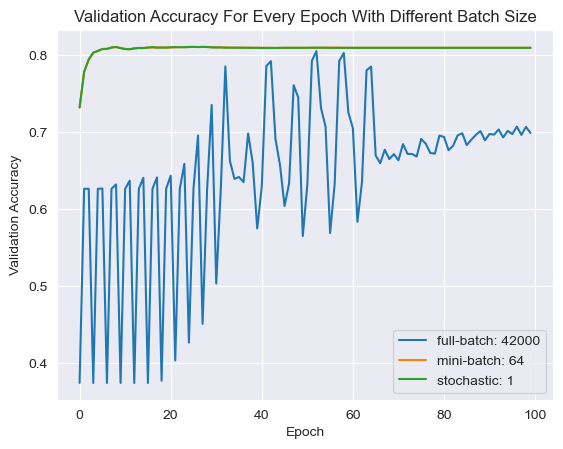

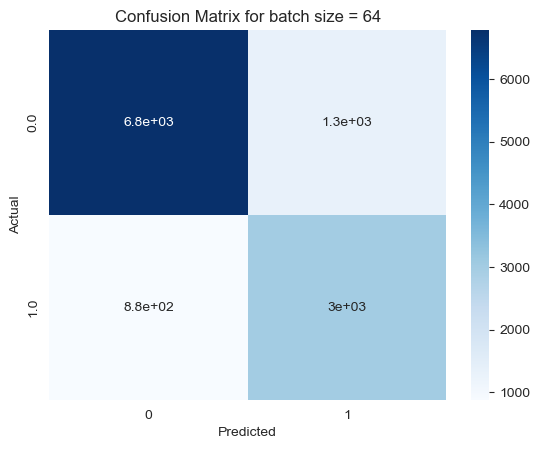

In [16]:
# Find the optimal batch size
batchSize = [42000, 64, 1]
batchSizeAcc = []
parameterList = []
plt.figure()
for size in batchSize:
    print('\nStart training for batch size =', size, '\n')
    model = LogisticRegression(epochs=100, learningRate=0.001, batchSize=size, initialization='gaussian')
    w, b, val_acc = model.fit(X_train, y_train, X_val, y_val)
    parameterList.append((w, b))
    getValAccPlot(val_acc, 'Batch Size')
    y_pred = model.predict(w, b, X_val, 0.5)
    accuracy = getAccuracy(y_pred, y_val)
    batchSizeAcc.append(accuracy)
    print('\nFinal accuracy for batch size =', size, 'is:', accuracy)
plt.legend(['full-batch: 42000', 'mini-batch: 64', 'stochastic: 1'])
plt.show()

maxBatchSize = batchSize[np.argmax(batchSizeAcc)]
model = LogisticRegression(epochs=100, learningRate=0.001, batchSize=maxBatchSize, initialization='gaussian')
w, b = parameterList[np.argmax(batchSizeAcc)]
y_pred = model.predict(w, b, X_test, 0.5)
title = 'Confusion Matrix for batch size = ' + str(maxBatchSize)
plt.title(title)
getConfusionMatrix(y_pred, y_test)
plt.show()


Start training for gaussian initialization

Epoch 0 finished. Accuracy is 0.7311666666666666
Epoch 1 finished. Accuracy is 0.7778333333333334
Epoch 2 finished. Accuracy is 0.7936666666666666
Epoch 3 finished. Accuracy is 0.8026666666666666
Epoch 4 finished. Accuracy is 0.8048333333333333
Epoch 5 finished. Accuracy is 0.8073333333333333
Epoch 6 finished. Accuracy is 0.8075
Epoch 7 finished. Accuracy is 0.8093333333333333
Epoch 8 finished. Accuracy is 0.81
Epoch 9 finished. Accuracy is 0.8088333333333333
Epoch 10 finished. Accuracy is 0.8076666666666666
Epoch 11 finished. Accuracy is 0.8071666666666667
Epoch 12 finished. Accuracy is 0.8081666666666667
Epoch 13 finished. Accuracy is 0.8086666666666666
Epoch 14 finished. Accuracy is 0.8086666666666666
Epoch 15 finished. Accuracy is 0.8093333333333333
Epoch 16 finished. Accuracy is 0.8095
Epoch 17 finished. Accuracy is 0.8093333333333333
Epoch 18 finished. Accuracy is 0.8095
Epoch 19 finished. Accuracy is 0.8091666666666667
Epoch 20 finish

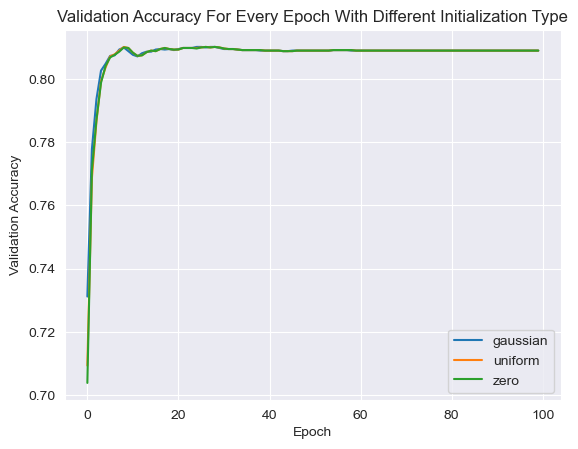

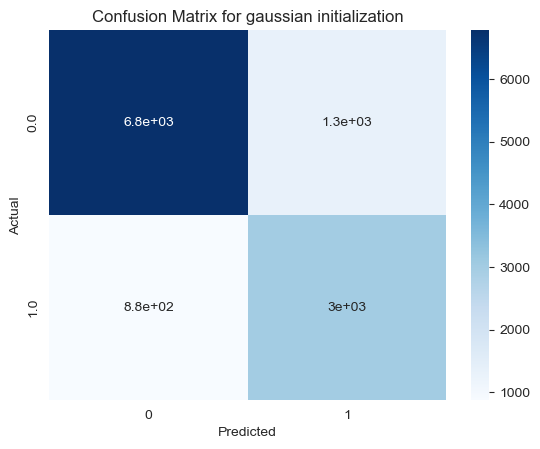

In [17]:
# Find the optimal initialization
initializationType = ['gaussian', 'uniform', 'zero']
initializationAcc = []
parameterList = []
plt.figure()
for inType in initializationType:
    print('\nStart training for', inType, 'initialization\n')
    model = LogisticRegression(epochs=100, learningRate=0.001, batchSize=64, initialization=inType)
    w, b, val_acc = model.fit(X_train, y_train, X_val, y_val)
    parameterList.append((w, b))
    getValAccPlot(val_acc, 'Initialization Type')
    y_pred = model.predict(w, b, X_val, 0.5)
    accuracy = getAccuracy(y_pred, y_val)
    initializationAcc.append(accuracy)
    print('\nFinal accuracy for for', inType, 'initialization is:', accuracy)
plt.legend(initializationType)
plt.show()

maxInitialization = initializationType[np.argmax(initializationAcc)]
model = LogisticRegression(epochs=100, learningRate=0.001, batchSize=64, initialization=maxInitialization)
w, b = parameterList[np.argmax(initializationAcc)]
y_pred = model.predict(w, b, X_test, 0.5)
title = 'Confusion Matrix for ' + str(maxInitialization) + ' initialization'
plt.title(title)
getConfusionMatrix(y_pred, y_test)
plt.show()


Start training for learning rate = 1 

Epoch 0 finished. Accuracy is 0.7338333333333333
Epoch 1 finished. Accuracy is 0.735
Epoch 2 finished. Accuracy is 0.7348333333333333
Epoch 3 finished. Accuracy is 0.7366666666666667
Epoch 4 finished. Accuracy is 0.7358333333333333
Epoch 5 finished. Accuracy is 0.7393333333333333
Epoch 6 finished. Accuracy is 0.7358333333333333
Epoch 7 finished. Accuracy is 0.7363333333333333
Epoch 8 finished. Accuracy is 0.733
Epoch 9 finished. Accuracy is 0.7363333333333333
Epoch 10 finished. Accuracy is 0.733
Epoch 11 finished. Accuracy is 0.735
Epoch 12 finished. Accuracy is 0.7333333333333333
Epoch 13 finished. Accuracy is 0.7373333333333333
Epoch 14 finished. Accuracy is 0.7338333333333333
Epoch 15 finished. Accuracy is 0.7371666666666666
Epoch 16 finished. Accuracy is 0.7361666666666666
Epoch 17 finished. Accuracy is 0.7353333333333333
Epoch 18 finished. Accuracy is 0.7426666666666667
Epoch 19 finished. Accuracy is 0.7375
Epoch 20 finished. Accuracy is 0.7

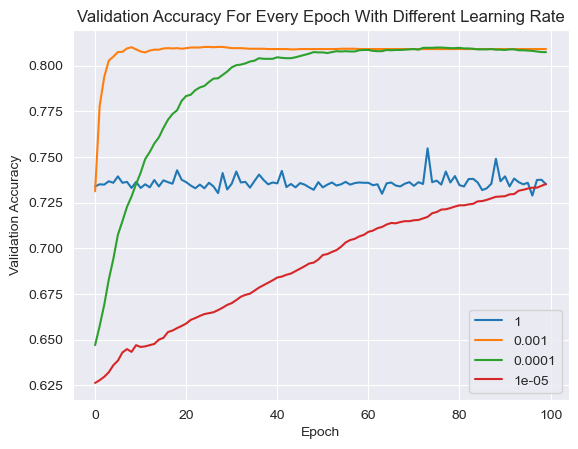

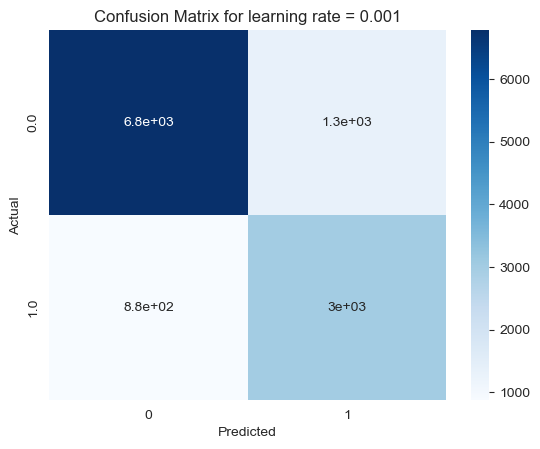

In [19]:
# Find the optimal learning rate
learningRate = [1, 0.001, 0.0001, 0.00001]
learningRateAcc = []
parameterList = []
plt.figure()
for rate in learningRate:
    print('\nStart training for learning rate =', rate, '\n')
    model = LogisticRegression(epochs=100, learningRate=rate, batchSize=64, initialization='gaussian')
    w, b, val_acc = model.fit(X_train, y_train, X_val, y_val)
    parameterList.append((w, b))
    getValAccPlot(val_acc, 'Learning Rate')
    y_pred = model.predict(w, b, X_val, 0.5)
    accuracy = getAccuracy(y_pred, y_val)
    learningRateAcc.append(accuracy)
    print('\nFinal accuracy for learning rate =', rate, 'is:', accuracy)
plt.legend(learningRate)
plt.show()

maxLearningRate = learningRate[np.argmax(learningRateAcc)]
model = LogisticRegression(epochs=100, learningRate=maxLearningRate, batchSize=64, initialization='gaussian')
w, b = parameterList[np.argmax(learningRateAcc)]
y_pred = model.predict(w, b, X_test, 0.5)
title = 'Confusion Matrix for learning rate = ' + str(maxLearningRate)
plt.title(title)
getConfusionMatrix(y_pred, y_test)
plt.show()


Start final training with best parameters

epochs=100, learningRate= 0.001 batchSize= 64 initialization= gaussian
Epoch 0 finished. Accuracy is 0.7311666666666666
Epoch 1 finished. Accuracy is 0.7778333333333334
Epoch 2 finished. Accuracy is 0.7936666666666666
Epoch 3 finished. Accuracy is 0.8026666666666666
Epoch 4 finished. Accuracy is 0.8048333333333333
Epoch 5 finished. Accuracy is 0.8073333333333333
Epoch 6 finished. Accuracy is 0.8075
Epoch 7 finished. Accuracy is 0.8093333333333333
Epoch 8 finished. Accuracy is 0.81
Epoch 9 finished. Accuracy is 0.8088333333333333
Epoch 10 finished. Accuracy is 0.8076666666666666
Epoch 11 finished. Accuracy is 0.8071666666666667
Epoch 12 finished. Accuracy is 0.8081666666666667
Epoch 13 finished. Accuracy is 0.8086666666666666
Epoch 14 finished. Accuracy is 0.8086666666666666
Epoch 15 finished. Accuracy is 0.8093333333333333
Epoch 16 finished. Accuracy is 0.8095
Epoch 17 finished. Accuracy is 0.8093333333333333
Epoch 18 finished. Accuracy is 0.

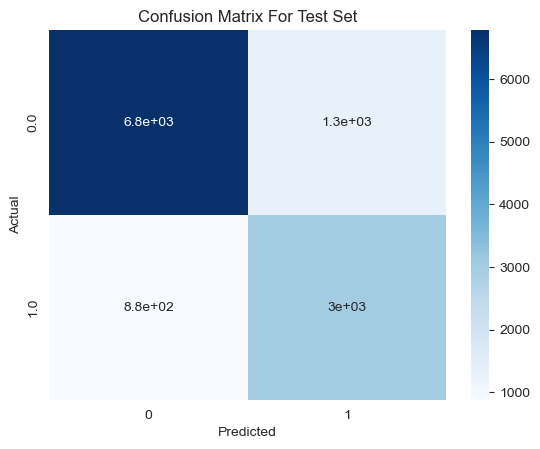

In [20]:
# Final training with the best hyperparameters
print('\nStart final training with best parameters\n')
print('epochs=100, learningRate=', maxLearningRate, 'batchSize=', maxBatchSize, 'initialization=', maxInitialization)
model = LogisticRegression(epochs=100, learningRate=maxLearningRate, batchSize=maxBatchSize,
                              initialization=maxInitialization)
w, b, val_acc = model.fit(X_train, y_train, X_val, y_val)
y_pred = model.predict(w, b, X_test, 0.5)
accuracy = getAccuracy(y_pred, y_test)
cm = getConfusionMatrix(y_pred, y_test)
plt.title('Confusion Matrix For Test Set')
plt.show()

In [21]:
# Calculate metrics
true_pos = np.diag(cm)[0]
false_pos = np.sum(cm, axis=1)[0] - true_pos

pre_denom = np.sum(cm, axis=1)[0]
rec_denom = np.sum(cm, axis=0)[0]
FPR_denom = np.sum(cm, axis=0)[1]

precision = true_pos/pre_denom
recall = true_pos/rec_denom
FPR = false_pos/FPR_denom
F1_beta_square = 1**2
F1_measure = ((1 + F1_beta_square)*precision*recall)/((F1_beta_square*precision)+recall)
F2_beta_square = 2**2
F2_measure = ((1 + F2_beta_square)*precision*recall)/((F2_beta_square*precision)+recall)
F05_beta_square = 0.5**2
F05_measure = ((1 + F05_beta_square)*precision*recall)/((F05_beta_square*precision)+recall)

print('\nAccuracy for test set is:', accuracy)
print('Precision for test set is:', precision)
print('Recall for test set is:', recall)
print('False Positive Rate (FPR) for test set is:', FPR)
print('F1 measure for test set is:', F1_measure)
print('F2 measure for test set is:', F2_measure)
print('F0.5 measure for test set is:', F05_measure)


Accuracy for test set is: 0.8158333333333333
Precision for test set is: 0.8361707377251418
Recall for test set is: 0.8848563968668407
False Positive Rate (FPR) for test set is: 0.30599078341013825
F1 measure for test set is: 0.8598249397437524
F2 measure for test set is: 0.874670933773809
F0.5 measure for test set is: 0.8454745035425606
